In [17]:
import pandas as pd
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
df = pd.read_csv("dataset_v02.csv")  # merge msf + medusa

print(df.head())
print("\nDataset shape:", df.shape)

   window_id           src_ip           dst_ip  mean_inter_arrival  \
0         14  192.168.153.138  192.168.153.149            0.000543   
1         14  192.168.153.138  192.168.153.149            0.003876   
2         16  192.168.153.138  192.168.153.149            0.000270   
3         16  192.168.153.138  192.168.153.149            0.003693   
4         16  192.168.153.138  192.168.153.149            0.013476   

   std_inter_arrival  packet_count  syn_count  rst_count  zero_payload_count  \
0           0.000613             4          2          1                   4   
1           0.012021            20          2          0                  10   
2           0.000261             4          2          1                   4   
3           0.007386            19          2          0                   9   
4           0.019905            21          2          0                  11   

   packet_size_std  unique_packet_sizes  flow_count_per_window  label  
0         0.000000        

In [19]:
FEATURES = [
"mean_inter_arrival",
"std_inter_arrival",
"packet_count",
"syn_count",
"rst_count",
"packet_size_std",
"unique_packet_sizes",
"zero_payload_count",
"flow_count_per_window"
]


LABEL = "label"
X = df[FEATURES]
y = df[LABEL]
print("Normal flows:", sum(y == 0))
print("Brute-force flows:", sum(y == 1))

Normal flows: 1397
Brute-force flows: 3923


In [20]:
from sklearn.utils import shuffle

# 1. Separate the classes
df_normal = df[df[LABEL] == 0]
df_attack = df[df[LABEL] == 1]

print(f"Original Normal count: {len(df_normal)}")
print(f"Original Attack count: {len(df_attack)}")

# 2. Calculate the target number of attack samples
# We want Normal to be 40%, so Attack must be 1.5x the size of Normal (60/40 ratio)
target_attack_count = int(len(df_normal) * (60 / 40))
print(f"Target Attack count: {target_attack_count}")

# 3. Downsample the Attack class
df_attack_downsampled = df_attack.sample(n=target_attack_count, random_state=42)

# 4. Combine and Shuffle
df_balanced = pd.concat([df_normal, df_attack_downsampled])
df_balanced = shuffle(df_balanced, random_state=42).reset_index(drop=True)

# 5. Verify
X = df_balanced[FEATURES]
y = df_balanced[LABEL]

print("\n=== Final Counts ===")
print("Normal flows:", sum(y == 0))
print("Brute-force flows:", sum(y == 1))
print(f"Normal Ratio: {sum(y==0)/len(y):.2%}")

Original Normal count: 1397
Original Attack count: 3923
Target Attack count: 2095

=== Final Counts ===
Normal flows: 1397
Brute-force flows: 2095
Normal Ratio: 40.01%


In [21]:
X_train, X_test, y_train, y_test = train_test_split(
X, y,
test_size=0.2,
stratify=y,
random_state=42
)

print("Train samples:", len(X_train))
print("Test samples:", len(X_test))

Train samples: 2793
Test samples: 699


In [22]:
pipeline = Pipeline([
("scaler", StandardScaler()),
("rf", RandomForestClassifier(
n_estimators=200,
max_depth=12,
min_samples_leaf=5,
class_weight="balanced",
random_state=42,
n_jobs=-1
))
])


In [23]:
pipeline.fit(X_train, y_train)
print("Model training completed")

Model training completed


In [25]:
y_pred = pipeline.predict(X_test)


print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, digits=4))



Classification Report:

              precision    recall  f1-score   support

           0     0.9654    0.9964    0.9807       280
           1     0.9976    0.9761    0.9867       419

    accuracy                         0.9843       699
   macro avg     0.9815    0.9863    0.9837       699
weighted avg     0.9847    0.9843    0.9843       699



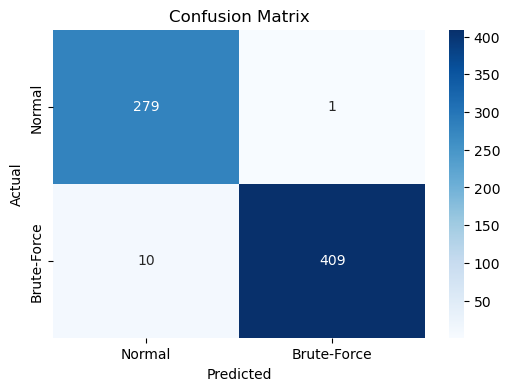

In [26]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Brute-Force'], yticklabels=['Normal', 'Brute-Force'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [27]:
rf = pipeline.named_steps["rf"]
importances = rf.feature_importances_


importance_df = pd.DataFrame({
"Feature": FEATURES,
"Importance": importances
}).sort_values(by="Importance", ascending=False)


importance_df

,Feature,Importance
8,flow_count_per_window,0.464416
3,syn_count,0.167750
1,std_inter_arrival,0.134842
0,mean_inter_arrival,0.065295
2,packet_count,0.060791
7,zero_payload_count,0.033800
5,packet_size_std,0.031328
6,unique_packet_sizes,0.030463
4,rst_count,0.011315


In [28]:
model_output = "ssh_ids_model.pkl"

joblib.dump({
"model": pipeline,
"features": FEATURES
}, model_output)

print(f"Model saved to {model_output}")


Model saved to ssh_ids_model.pkl
